In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import soaplite
import soaputils as su
import genBasis
import ase
from ase.visualize import view
from ase.build import bulk
import numpy as np
from numpy.linalg import svd
import matplotlib as matplotlib
import matplotlib.pyplot as p
import numpy.linalg as nl
from scipy.optimize import fmin
import scipy.optimize as op
import time
%matplotlib notebook

In [2]:
rCut = 10.0
NradBas = 5
Lmax = 5
myAlphas, myBetas = genBasis.getBasisFunc(rCut, NradBas)

struct1 = ase.io.read(currentdir + "/glass_cube_CuZr.cfg")
mat1 = soaplite.get_periodic_soap_structure(struct1, myAlphas, myBetas, rCut, NradBas, Lmax)

struct2 = bulk('Cu', 'fcc', a=3.6, cubic=True)
struct2 = soaplite._get_supercell(struct2, rCut=2.0)
mat2 = soaplite.get_periodic_soap_structure(struct2, myAlphas, myBetas, rCut, NradBas, Lmax)

a0 = 4.0
c0 = 1*a0
struct3 = bulk('Au', 'fcc', a=a0, cubic=True)
struct3.set_cell(np.diag((a0,a0,c0)), scale_atoms=True)
struct3.set_chemical_symbols(('Au','Cu','Cu','Au'))
struct3 = soaplite._get_supercell(struct3, rCut=2.0)
mat3 = soaplite.get_periodic_soap_structure(struct3, myAlphas, myBetas, rCut, NradBas, Lmax)

#p.matshow(mat1)
#p.matshow(mat3)

526.6094264044694
90


<IPython.core.display.Javascript object>


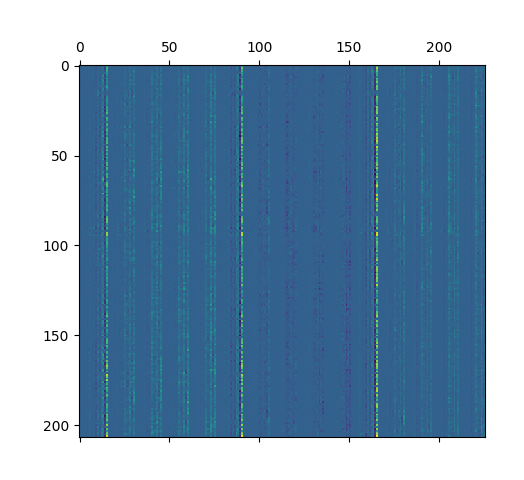

131.6850887322522


In [3]:
# calculates the 'block norm'
order = 2
mat0 = mat1
struct0 = struct1.copy()
print(nl.norm(mat0, ord=order))
symbols = struct0.get_chemical_symbols()
uSym = len(np.unique(symbols))
numBlocks = int(uSym*(uSym + 1)/2)
rowsBlock = int(np.shape(mat1)[1]/numBlocks)
print(rowsBlock)
mat = np.zeros((np.shape(mat0)[0],1))
frac = 0.17
sumNorm = 0.0
for i in np.arange(numBlocks):
    mat = np.append(mat,mat0[:,i*rowsBlock+int(frac*rowsBlock):(i+1)*rowsBlock],axis=1)
    #mat = mat1[:,i*rowsBlock:(i+1)*rowsBlock]
    #sumNorm += np.power(nl.norm(mat[:,int(frac*rowsBlock):],ord=order),order)
#sumNorm = np.power(sumNorm,1/ord)
p.matshow(mat)
print(nl.norm(mat,ord=order))

Number of Atoms: 30
Singular-Value norm: 318.855584
Full Matrix norm: 154.444932
Block matrix norm: 63.909718


<IPython.core.display.Javascript object>


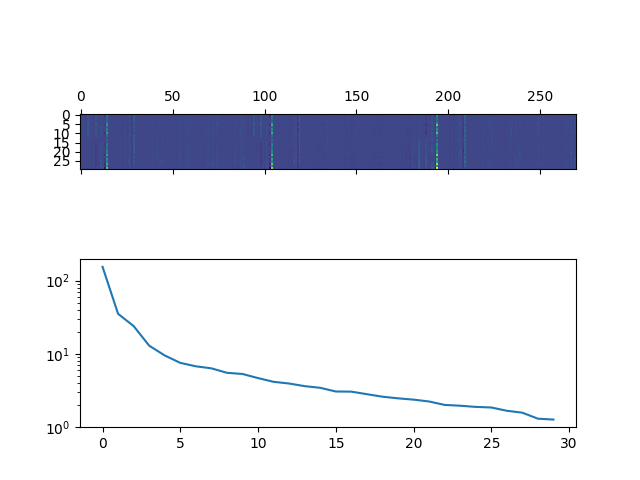

Time passed: 66.050195 s
Iterations: 69
Singular-Value norm: 2835.319487
Full Matrix norm: 1503.235587
Block matrix norm: 754.545298


<IPython.core.display.Javascript object>


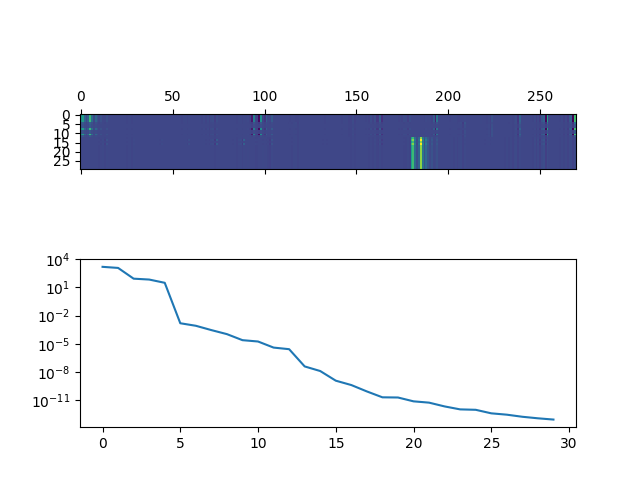

In [5]:
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
x0 = su.rand_pos(atoms_test).get_positions()
t0 = time.time()
N = len(atoms_test.get_positions())*3
print('Number of Atoms: %i' %(N/3))
bounds_obj = [(0,10)]*N
su.show_res(atoms_test, x0, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(su.soap_norm, x0, method='L-BFGS-B',args=(atoms_test, myAlphas, myBetas, rCut, NradBas, Lmax, True, True),bounds=bounds_obj,  options=op_options)
t1 = time.time()
dt = t1 - t0
print('Time passed: %f s' %dt)
print('Iterations: %i' %res_obj.nit)
xopt = res_obj.x
su.show_res(atoms_test, xopt, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)

In [ ]:
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
x0 = su.rand_pos(atoms_test).get_positions()
t0 = time.time()
N = len(atoms_test.get_positions())*3
print('Number of Atoms: %i' %(N/3))
bounds_obj = [(0,10)]*N
periodic = False
su.show_res(atoms_test, x0, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(su.norm_block, x0, method='L-BFGS-B',args=(atoms_test, 2, 0.3, myAlphas, myBetas, rCut, NradBas, Lmax, periodic),bounds=bounds_obj,  options=op_options)
t1 = time.time()
dt = t1 - t0
print('Time passed: %f s' %dt)
print('Iterations: %i' %res_obj.nit)
xopt = res_obj.x
su.show_res(atoms_test, xopt, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=periodic)

In [9]:
atoms_test.set_positions(np.reshape(xopt,(30,3)))
view(atoms_test)
print(atoms_test.get_positions())

[[7.55080207e+00 1.00000000e+01 9.99433935e+00]
 [7.55078855e+00 1.00000000e+01 9.99433925e+00]
 [8.41928326e-06 4.97831393e+00 4.98047198e+00]
 [9.99231015e+00 4.98351986e+00 4.98556980e+00]
 [7.55078619e+00 1.00000000e+01 9.99433924e+00]
 [8.23411146e-06 4.97832123e+00 4.98046522e+00]
 [9.99231038e+00 4.98352043e+00 4.98557124e+00]
 [8.58841398e-06 4.97832050e+00 4.98045681e+00]
 [7.04504188e-06 4.97831653e+00 4.98046237e+00]
 [7.55080342e+00 1.00000000e+01 9.99433939e+00]
 [8.94723956e-06 4.97831539e+00 4.98047554e+00]
 [7.55079841e+00 1.00000000e+01 9.99433565e+00]
 [7.54077817e+00 2.06168485e-02 9.98659051e+00]
 [8.22352671e-06 4.97831953e+00 4.98045997e+00]
 [7.12768216e-06 4.97832408e+00 4.98047353e+00]
 [6.48970161e-06 4.97831770e+00 4.98046441e+00]
 [7.54094066e+00 5.72322383e-03 0.00000000e+00]
 [8.58492452e-06 4.97831800e+00 4.98046144e+00]
 [7.54090973e+00 5.72288455e-03 0.00000000e+00]
 [6.42738503e-06 4.97831713e+00 4.98045812e+00]
 [7.55079757e+00 1.00000000e+01 9.994333